In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# for sake of simplicity, we will just import everything from desc
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

print_backend_info()

DESC version=0.15.0+555.g9b2e71684.
Using JAX backend: jax version=0.7.2, jaxlib version=0.7.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.73 GB available memory.


In [4]:
# includes all particle tracing capabilities and particle initialization
from desc.particles import *
# includes different solvers, stepsize controller and bunch of other tools for ODE integration
from diffrax import *

# Alpha Particle Trajectory Optimization in DESC

To run the notebook, please checkout to `rc/particles` branch,

```bash
git checkout rc/particles
git pull
```

The results presented in this notebook are not great, one needs to run it with more particles, longer integration time and possibly better objective weights to get better results. The aim for this notebook is to primarly describe the use of particle tracing in an objective. Please reach out to Yigit Gunsur Elmacioglu (yigit.elma@princeton.edu) for further questions.

In [ ]:
from desc.objectives.objective_funs import _Objective
from desc.particles import _trace_particles

class DirectParticleTracing(_Objective):
    """Confinement metric for radial transport from direct tracing.

    Traces particles in flux coordinates within the equilibrium, and
    returns a confinement metric based off of the average deviation of
    the particle trajectory from its initial flux surface. The trajectories
    are traced and a line is fitted to the radial position vs time,
    and the slope of this line is used as the metric.

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium that will be optimized to satisfy the Objective.
    iota_grid : Grid, optional
        Grid to evaluate rotational transform profile on.
        Defaults to ``LinearGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid)``.
    particles : ParticleInitializer
        should initialize them in flux coordinates, same seed
        will be used each time.
    model : TrajectoryModel
        should be either Vacuum or SlowingDown

    """

    __doc__ = __doc__.rstrip() + collect_docs(
        target_default="``target=0``.", bounds_default="``target=0``."
    )
    _static_attrs = _Objective._static_attrs + [
        "_trace_particles",
        "_max_steps",
        "_has_iota_profile",
        "_stepsize_controller",
        "_adjoint",
        "_event",
        "_particle_chunk_size",
    ]

    _coordinates = "rtz"
    _units = "(dimensionless)"
    _print_value_fmt = "Particle Confinement error: "

    def __init__(
        self,
        eq,
        particles,
        model,
        solver=Tsit5(),  # on CPU, Tsit5(scan_kind="bounded") is recommended
        ts=jnp.arange(0, 1e-3, 100),
        iota_grid=None,
        stepsize_controller=None,
        adjoint=RecursiveCheckpointAdjoint(),
        max_steps=None,
        min_step_size=1e-8,
        particle_chunk_size=None,
        target=None,
        bounds=None,
        weight=1,
        normalize=False,
        normalize_target=False,
        loss_function=None,
        deriv_mode="auto",
        name="Particle Confinement",
        jac_chunk_size=None,
    ):
        if target is None and bounds is None:
            target = 0
        self._ts = jnp.asarray(ts)
        self._adjoint = adjoint
        if max_steps is None:
            max_steps = 10
            max_steps = int((ts[-1] - ts[0]) / min_step_size * max_steps)
        self._max_steps = max_steps
        self._min_step_size = min_step_size
        self._stepsize_controller = (
            stepsize_controller
            if stepsize_controller is not None
            else PIDController(rtol=1e-4, atol=1e-4, dtmin=min_step_size)
        )
        self._iota_grid = iota_grid
        assert model.frame == "flux", "can only trace in flux coordinates"
        self._model = model
        self._particles = particles
        self._solver = solver
        self._has_iota_profile = eq.iota is not None
        self._particle_chunk_size = particle_chunk_size
        super().__init__(
            things=eq,
            target=target,
            bounds=bounds,
            weight=weight,
            normalize=normalize,
            normalize_target=normalize_target,
            loss_function=loss_function,
            deriv_mode=deriv_mode,
            name=name,
            jac_chunk_size=jac_chunk_size,
        )

    def build(self, use_jit=True, verbose=1):
        """Build constant arrays.

        Parameters
        ----------
        use_jit : bool, optional
            Whether to just-in-time compile the objective and derivatives.
        verbose : int, optional
            Level of output.

        """
        eq = self.things[0]
        if self._iota_grid is None:
            iota_grid = LinearGrid(
                L=eq.L_grid, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=False
            )
        else:
            iota_grid = self._iota_grid

        self._x0, self._model_args = self._particles.init_particles(
            model=self._model, field=eq
        )

        # one metric per particle
        self._dim_f = self._x0.shape[0]

        # tracing uses carteasian coordinates internally, the termainating event
        # must look at rho values by conversion
        def default_event(t, y, args, **kwargs):
            i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
            return jnp.logical_or(i < 0.0, i > 1.0)

        self._event = Event(default_event)

        timer = Timer()
        if verbose > 0:
            print("Precomputing transforms")
        timer.start("Precomputing transforms")

        self._iota_profiles = get_profiles(["iota"], obj=eq, grid=iota_grid)
        self._iota_transforms = get_transforms(["iota"], obj=eq, grid=iota_grid)
        self._iota_power_series = PowerSeriesProfile(sym="even")
        self._iota_power_series.change_resolution(L=eq.L)

        timer.stop("Precomputing transforms")
        if verbose > 1:
            timer.disp("Precomputing transforms")

        super().build(use_jit=use_jit, verbose=verbose)

    def compute(self, params, constants=None):
        """Compute particle tracing metric errors.

        Parameters
        ----------
        params : dict
            Dictionary of equilibrium degrees of freedom, eg Equilibrium.params_dict
        constants : dict
            Dictionary of constant data, eg transforms, profiles etc. Defaults to
            self.constants

        Returns
        -------
        f : ndarray
            Average deviation in rho from initial surface, for each particle.
        """
        if not self._has_iota_profile:
            # compute and fit iota profile beforehand, as
            # particle trace only computes things one point at a time
            # and thus cannot do the flux surf averages required for iota
            data = compute_fun(
                "desc.equilibrium.equilibrium.Equilibrium",
                ["rho", "iota"],
                params,
                self._iota_transforms,
                self._iota_profiles,
            )
            iota_values = self._iota_transforms["grid"].compress(data["iota"])
            rho = self._iota_transforms["grid"].compress(data["rho"])
            x = rho**2
            iota_prof = self._iota_power_series
            order = iota_prof.basis.L // 2
            iota_params = jnp.polyfit(
                x, iota_values, order, rcond=None, w=None, full=False
            )[::-1]
            params["i_l"] = iota_params
        else:
            iota_prof = None

        rpz, _ = _trace_particles(
            field=self.things[0],
            y0=self._x0,
            model=self._model,
            model_args=self._model_args,
            ts=self._ts,
            params=params,
            stepsize_controller=self._stepsize_controller,
            saveat=SaveAt(ts=self._ts),
            max_steps=self._max_steps,
            min_step_size=self._min_step_size,
            solver=self._solver,
            adjoint=self._adjoint,
            event=self._event,
            options={"iota": iota_prof},
            chunk_size=self._particle_chunk_size,
            throw=False,
            return_aux=False,
        )

        # rpz is shape [N_particles, N_time, 3], take just index rho
        rhos = rpz[:, :, 0]
        rho0s = self._x0[:, 0]

        def fit_line(y):
            ts = self._ts
            # replace nans with zeros, since (0,0) is already the initial
            # point, this will not affect the fit
            y = jnp.where(jnp.isnan(y), 0.0, y)
            ts = jnp.where(jnp.isnan(y), 0.0, ts)
            coeffs = jnp.polyfit(ts, y, 1)
            return coeffs[0]

        slopes = vmap(fit_line)(rhos - rho0s[:, None]) * self._ts[-1]
        # slopes = rhos - rho0s[:, None]
        return slopes

In [31]:
name = "precise_QA"
try:
    # if the file exists, load it
    eq = desc.io.load(f"{name}_vacuum_scaled_solved.h5")
    eqi_scaled = eq.copy()
except:
    # else, create it from scratch
    eqi = get(name)
    eq = rescale(eq=eqi, L=("a", 1.7044), B=("<B>", 5.86), copy=True)
    eq.pressure = 0
    eq.current = 0
    eq.solve(ftol=1e-4, verbose=1);
    eqi_scaled = eq.copy()
    eq.save(f"{name}_vacuum_scaled_solved.h5")

# The Vacuum Guiding Center model assumes a constant pressure profile and zero current
# If the equilibrium does not satisfy these conditions, raise an error.
if (eq.p_l[1:] != 0).any():
    raise ValueError("Equilibrium doesn't have constant pressure, please use a vacuum equilibrium.")
if (eq.c_l != 0).any():
    raise ValueError("Equilibrium has non-zero current, please use a vacuum equilibrium.")

In [32]:
# create N particles between rho=0.1 and rho=0.3 randomly
N = 1  # number of particles traced
RHO0 = 0.1 + np.random.rand(N) * 0.2

model_flux = VacuumGuidingCenterTrajectory(frame="flux")
particles_flux = ManualParticleInitializerFlux(
    rho0=RHO0,
    theta0=np.random.rand(N) * 2 * np.pi,
    zeta0=np.random.rand(N) * 2 * np.pi,
    xi0=np.random.rand(N), # add negative region too
    E=3.5e6,
)

## Test Derivatives

In [36]:
objective = DirectParticleTracing(
    eq,
    particles=particles_flux,
    model=model_flux,
    solver=Tsit5(),
    ts=np.linspace(0, 5e-6, 1000),
    min_step_size=1e-8,
    stepsize_controller=PIDController(rtol=1e-5, atol=1e-5, dtmin=1e-8),
    adjoint=RecursiveCheckpointAdjoint(),  # default is RecursiveCheckpointAdjoint() (reverse mode)
    deriv_mode="rev",
)
obj = ObjectiveFunction(objective)
# obj = ObjectiveFunction(ForceBalance(eq))
# obj = ObjectiveFunction(QuasisymmetryTwoTerm(eq))
obj.build(use_jit=True)
x = obj.x(eq)
f = obj.compute_scalar(x)

Building objective: Particle Confinement
Precomputing transforms


In [37]:
f

Array(0.1593, dtype=float64)

In [38]:
def get_f_R1_no_solve(idx, dx):
    eq0 = eq.copy()
    eq0.R_lmn[idx] += dx
    eq0.surface = eq0.get_surface_at(rho=1)
    eq0.axis = eq0.get_axis()
    x = obj.x(eq0)
    f1 = obj.compute_scalar(x)
    return f1

In [46]:
idx0 = eq.R_basis.get_idx(0,0,0)
divs = [1e4]
colors = ["ro", "bo", "go", "mo"]

arr1 = np.arange(eq.R_basis.num_modes)
df = obj.grad(x)
fds = []
fd1s = []
fd2s = []

for idx in arr1:
    fd = []
    fd1 = []
    fd2 = []
    xi = x[idx]

    for div in divs:
        dx = xi / div
        dx = dx if dx > 1e-9 else 1e-9
        f1 = get_f_R1_no_solve(idx, dx)
        fm1 = get_f_R1_no_solve(idx, -dx)
        fd.append((f1-fm1)/(2*dx))
        fd1.append(f1)
        fd2.append(fm1)

    fds.append(fd)
    fd1s.append(fd1)
    fd2s.append(fd2)

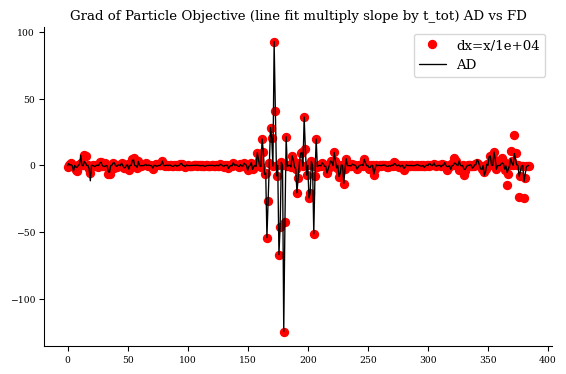

In [47]:
fds = np.array(fds)
fd1s = np.array(fd1s)
fd2s = np.array(fd2s)
arr = np.arange(100, 300)
for i in range(1):
    plt.plot(fds[:, i], colors[i], label=f"dx=x/{divs[i]:.0e}")
# high = fds[arr, 2]
# high = np.where(high > 700, 700, high)
# high = np.where(high < -400, -400, high)
# plt.plot(high, colors[2], label=f"dx/{divs[2]:.0e}")
plt.plot(df[: eq.R_basis.num_modes], "k", label="AD")
plt.legend()
plt.title("Grad of Particle Objective (line fit multiply slope by t_tot) AD vs FD");

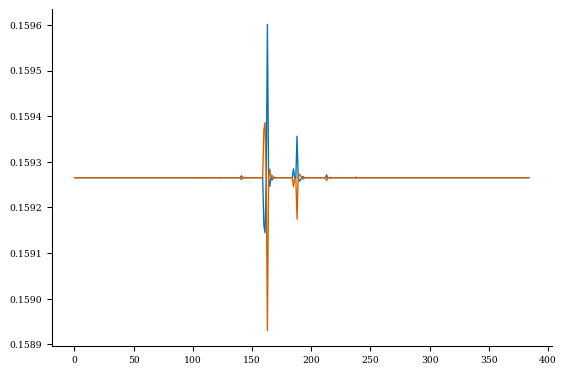

In [48]:
plt.plot(fd1s)
plt.plot(fd2s)

In [ ]:
eq0 = eq.copy()
eq0.R_lmn[158] += eq0.R_lmn[158]
fig = plot_particle_trajectories(
    eq0,
    model_flux,
    particles_flux,
    ts=np.linspace(0, 5e-6, 1000),
    rtol=1e-5,
    atol=1e-5,
    min_step_size=1e-8,
    adjoint=RecursiveCheckpointAdjoint(),
)
plot_particle_trajectories(
    eq,
    model_flux,
    particles_flux,
    ts=np.linspace(0, 5e-6, 1000),
    rtol=1e-5,
    atol=1e-5,
    min_step_size=1e-8,
    adjoint=RecursiveCheckpointAdjoint(),
    fig=fig,
    color=["red"],
)

In [ ]:
obj = ObjectiveFunction(
    DirectParticleTracing(
        eq,
        particles=particles_flux,
        model=model_flux,
        solver=Tsit5(),
        ts=np.linspace(0, 1e-5, 1000),
        min_step_size=1e-8,
        stepsize_controller=PIDController(rtol=1e-3, atol=1e-4, dtmin=1e-8),
        adjoint=ForwardMode(),  # default is RecursiveCheckpointAdjoint() (reverse mode)
        deriv_mode="fwd",
    )
)
con = ObjectiveFunction(ForceBalance(eq))
prox = ProximalProjection(obj, con, eq)
prox.build()

In [ ]:
prox.x(eq).shape

## Optimization

In [ ]:
k = 1
print(f"=========== Optimizing with modes  > {k} ===========")
AR = eq.compute("R0/a")["R0/a"]
obj = ObjectiveFunction(
    [
        DirectParticleTracing(
            eq,
            particles=particles_flux,
            model=model_flux,
            solver=Tsit5(),
            ts=np.linspace(0, 1e-3, 1000),
            min_step_size=1e-8,
            stepsize_controller=PIDController(rtol=1e-3, atol=1e-4, dtmin=1e-8),
            adjoint=ForwardMode(), # default is RecursiveCheckpointAdjoint() (reverse mode)
            deriv_mode="fwd",
        ),
        AspectRatio(eq, target=AR, weight=1e2), # keep aspect ratio similar
    ]
)
if eq.iota is not None:
    constraints = (ForceBalance(eq), FixPressure(eq), FixPsi(eq), FixIota(eq))
else:
    constraints = (ForceBalance(eq), FixPressure(eq), FixPsi(eq), FixCurrent(eq))
R_modes = eq.surface.R_basis.modes[np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :]
Z_modes = eq.surface.Z_basis.modes[np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :]
bdry_constraints = (
    FixBoundaryR(eq=eq, modes=R_modes),
    FixBoundaryZ(eq=eq, modes=Z_modes),   
)

optimizer = Optimizer("proximal-lsq-exact")
eq.optimize(
    optimizer=optimizer,
    objective=obj,
    constraints=constraints + bdry_constraints,
    verbose=3,
    maxiter=25,
    ftol=1e-3,
    gtol=1e-3,
    xtol=1e-10,
    options={
        "max_nfev": 30, 
        "initial_trust_ratio": 1e-2
    }
);